In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os
sns.set_style('darkgrid')

In [3]:
data_dir = "fire_dataset/"
print(os.listdir(data_dir))

['fire_images', 'non_fire_images']


In [4]:
df = pd.DataFrame(columns=['path','label'])

for dirname, _, filenames in os.walk(data_dir+'fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

for dirname, _, filenames in os.walk(data_dir+'non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))
        
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,path,label
0,fire_dataset/fire_images\51.jpg,fire
1,fire_dataset/fire_images\fire.29.png,fire
2,fire_dataset/fire_images\img_343.jpg,fire
3,fire_dataset/non_fire_images\305.jpg,non_fire
4,fire_dataset/non_fire_images\269.jpg,non_fire
5,fire_dataset/non_fire_images\295.jpg,non_fire
6,fire_dataset/non_fire_images\img_52.jpg,non_fire
7,fire_dataset/fire_images\53.jpg,fire
8,fire_dataset/fire_images\img_410.jpg,fire
9,fire_dataset/non_fire_images\113.jpg,non_fire


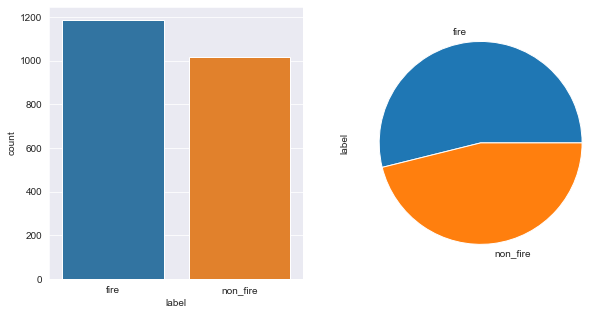

In [6]:
fig, ax =plt.subplots(1,2)
sns.countplot(x=df["label"], ax=ax[0]) 
df['label'].value_counts().plot.pie(figsize=(5,5),  ax=ax[1])
fig.set_figheight(5)
fig.set_figwidth(10)

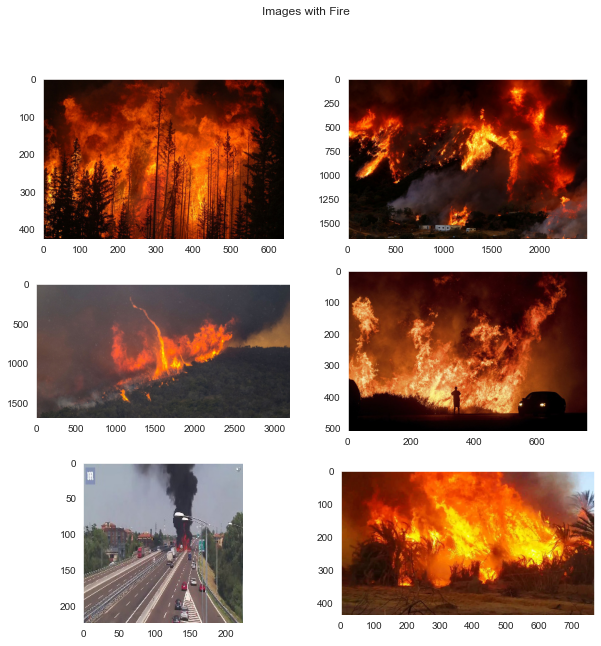

In [7]:
label = 'fire' 
data = df[df['label'] == label]
sns.set_style('dark')
pics = 6
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)    

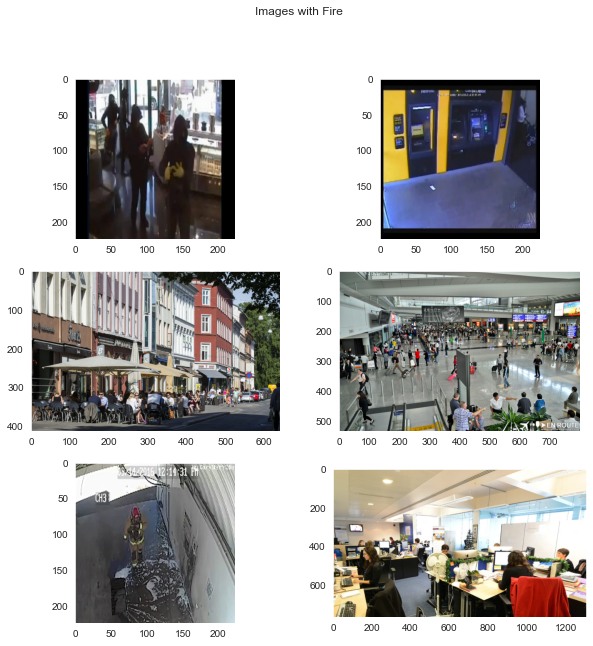

In [8]:
label = 'non_fire' 
data = df[df['label'] == label]
sns.set_style('dark')


pics = 6
fig,ax = plt.subplots(int(pics//2),2,figsize=(10,10))
plt.suptitle('Images with Fire')
ax = ax.ravel()
for i in range((pics//2)*2):
    path = data.sample(1).loc[:,'path'].to_numpy()[0]
    img = image.load_img(path)
    img = image.img_to_array(img)/255
    ax[i].imshow(img)

In [9]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,fire_dataset/fire_images\51.jpg,fire,2592,3872
1,fire_dataset/fire_images\fire.29.png,fire,720,1280
2,fire_dataset/fire_images\img_343.jpg,fire,224,224
3,fire_dataset/non_fire_images\305.jpg,non_fire,340,340
4,fire_dataset/non_fire_images\269.jpg,non_fire,327,470


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.3,
)

In [12]:
train_gen = generator.flow_from_dataframe(df,
                                          x_col='path',
                                          y_col='label',
                                          target_size=(224,224),
                                          class_mode='binary',
                                          subset='training')
val_gen = generator.flow_from_dataframe(df,
                                        x_col='path',
                                        y_col='label',
                                        target_size=(224,224),
                                        class_mode='binary',
                                        subset='validation')

Found 1543 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


In [13]:
class_indices = {}
for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]] = key
    
print(class_indices)

{0: 'fire', 1: 'non_fire'}


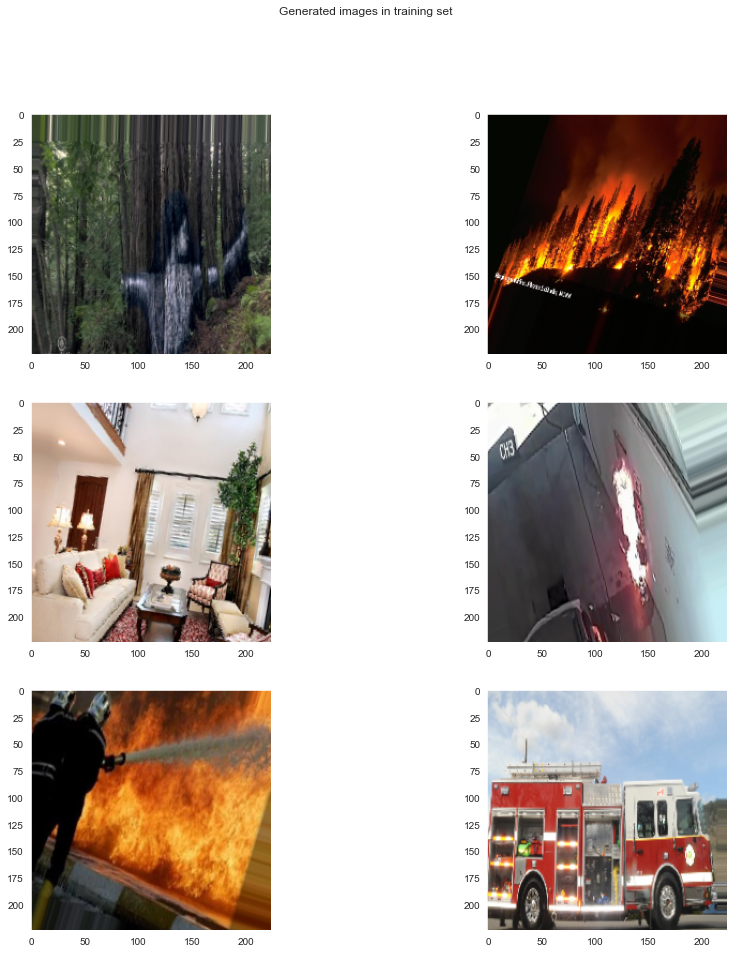

In [14]:
sns.set_style('dark')
pics = 6
fig,ax = plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])    

In [15]:
train_gen[0][0].shape

(32, 224, 224, 3)

# CNN model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [15]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size = (2,2),activation='relu',input_shape = (224,224,3)))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(filters=128,kernel_size=(2,2),activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 223, 223, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 54, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 93312)             0

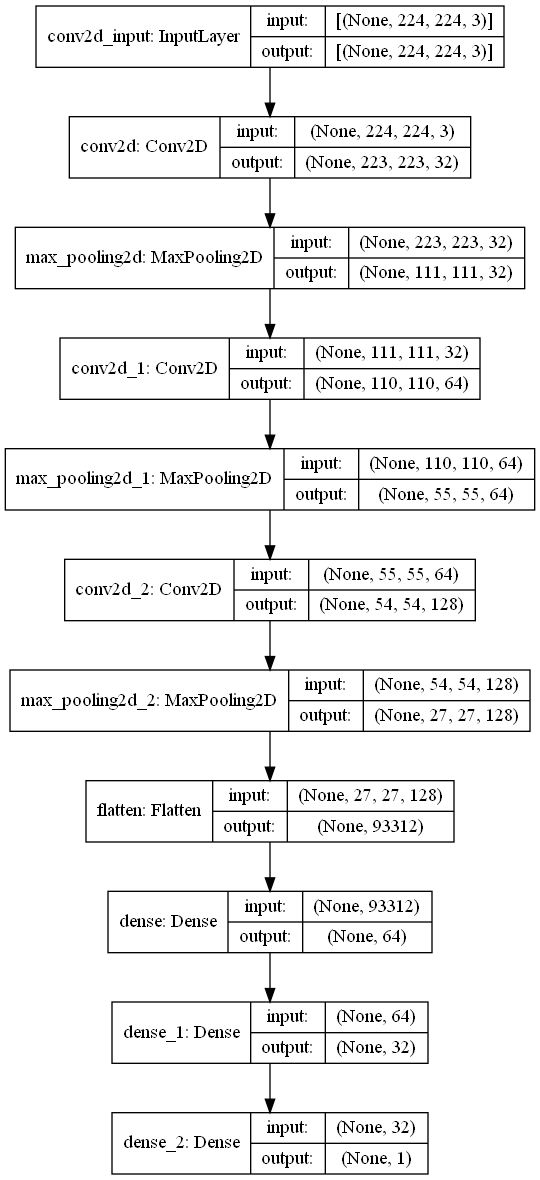

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stoppping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

In [24]:
history = model.fit(x=train_gen,batch_size=32,epochs=15,validation_data=val_gen,callbacks=[early_stoppping,reduce_lr_on_plateau])

Epoch 1/15
49/49 [==============================] - 63s 1s/step - loss: 0.5380 - accuracy: 0.7369 - val_loss: 0.4771 - val_accuracy: 0.7394
Epoch 2/15
49/49 [==============================] - 49s 1s/step - loss: 0.4051 - accuracy: 0.8095 - val_loss: 0.3241 - val_accuracy: 0.8773
Epoch 3/15
49/49 [==============================] - 50s 1s/step - loss: 0.3156 - accuracy: 0.8652 - val_loss: 0.3400 - val_accuracy: 0.8485
Epoch 4/15
49/49 [==============================] - 51s 1s/step - loss: 0.3056 - accuracy: 0.8736 - val_loss: 0.2950 - val_accuracy: 0.8773
Epoch 5/15
49/49 [==============================] - 51s 1s/step - loss: 0.2824 - accuracy: 0.8788 - val_loss: 0.2504 - val_accuracy: 0.9045
Epoch 6/15
49/49 [==============================] - 51s 1s/step - loss: 0.2236 - accuracy: 0.9196 - val_loss: 0.2419 - val_accuracy: 0.9076
Epoch 7/15
49/49 [==============================] - 52s 1s/step - loss: 0.2165 - accuracy: 0.9151 - val_loss: 0.2553 - val_accuracy: 0.8985
Epoch 8/15
49/49 [==

In [105]:
history= model5.history.history

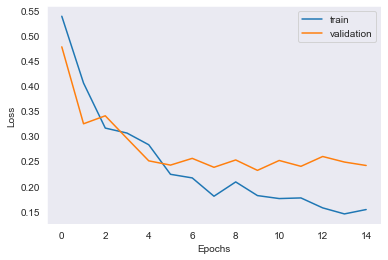

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

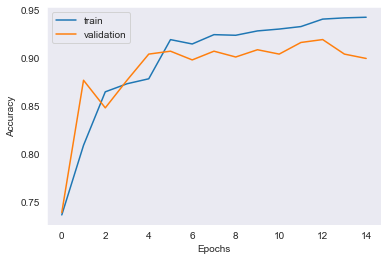

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation'])

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# VGG19

In [23]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [26]:
vgg = VGG19(include_top = False,weights="imagenet", input_shape = (224,224,3))
vgg.trainable = False

x = Flatten()(vgg.output)
x = Dense(64,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
output_to_model = Dense(1,activation = 'sigmoid')(x)
model3 = Model(vgg.input, output_to_model)
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
model3.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [15]:
history3 = model3.fit(x = train_gen,batch_size=32,epochs=10, validation_data = val_gen)

Epoch 1/10
49/49 [==============================] - 80s 1s/step - loss: 0.5982 - accuracy: 0.6986 - val_loss: 0.3864 - val_accuracy: 0.8182
Epoch 2/10
49/49 [==============================] - 55s 1s/step - loss: 0.3443 - accuracy: 0.8548 - val_loss: 0.3228 - val_accuracy: 0.8470
Epoch 3/10
49/49 [==============================] - 58s 1s/step - loss: 0.2679 - accuracy: 0.8957 - val_loss: 0.3156 - val_accuracy: 0.8682
Epoch 4/10
49/49 [==============================] - 56s 1s/step - loss: 0.2413 - accuracy: 0.9034 - val_loss: 0.2385 - val_accuracy: 0.9106
Epoch 5/10
49/49 [==============================] - 56s 1s/step - loss: 0.2074 - accuracy: 0.9274 - val_loss: 0.2848 - val_accuracy: 0.8924
Epoch 6/10
49/49 [==============================] - 56s 1s/step - loss: 0.1961 - accuracy: 0.9216 - val_loss: 0.2680 - val_accuracy: 0.9045
Epoch 7/10
49/49 [==============================] - 56s 1s/step - loss: 0.1418 - accuracy: 0.9469 - val_loss: 0.3004 - val_accuracy: 0.8742
Epoch 8/10
49/49 [==

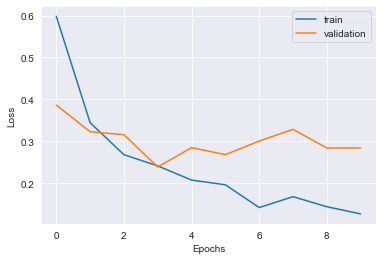

In [16]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['train', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

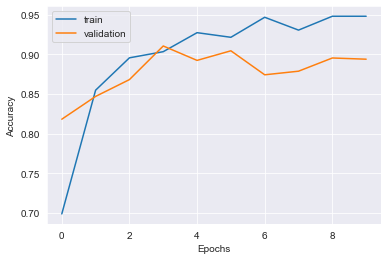

In [17]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.legend(['train', 'validation'])

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# Resnet50


In [24]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout

In [25]:
resn = ResNet50V2(include_top = False,input_shape = (224,224,3))
resn.trainable = False
x = Flatten()(resn.output)
x = Dense(64,activation = 'relu')(x)
x = Dense(32,activation = 'relu')(x)
x = Dense(1,activation = 'sigmoid')(x)
model5 = Model(resn.input,x)

In [26]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [27]:
model5.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [28]:
history5 = model5.fit(x = train_gen,batch_size=32,epochs=10, validation_data = val_gen)

Epoch 1/10
49/49 [==============================] - 63s 1s/step - loss: 0.6699 - accuracy: 0.8658 - val_loss: 0.2077 - val_accuracy: 0.9576
Epoch 2/10
49/49 [==============================] - 55s 1s/step - loss: 0.1719 - accuracy: 0.9514 - val_loss: 0.2296 - val_accuracy: 0.9606
Epoch 3/10
49/49 [==============================] - 56s 1s/step - loss: 0.1566 - accuracy: 0.9598 - val_loss: 0.2051 - val_accuracy: 0.9545
Epoch 4/10
49/49 [==============================] - 59s 1s/step - loss: 0.0948 - accuracy: 0.9767 - val_loss: 0.2403 - val_accuracy: 0.9500
Epoch 5/10
49/49 [==============================] - 57s 1s/step - loss: 0.0774 - accuracy: 0.9760 - val_loss: 0.1826 - val_accuracy: 0.9621
Epoch 6/10
49/49 [==============================] - 56s 1s/step - loss: 0.0512 - accuracy: 0.9851 - val_loss: 0.2012 - val_accuracy: 0.9667
Epoch 7/10
49/49 [==============================] - 56s 1s/step - loss: 0.0582 - accuracy: 0.9825 - val_loss: 0.3626 - val_accuracy: 0.9561
Epoch 8/10
49/49 [==

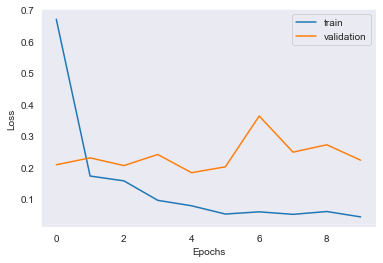

In [29]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.legend(['train', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

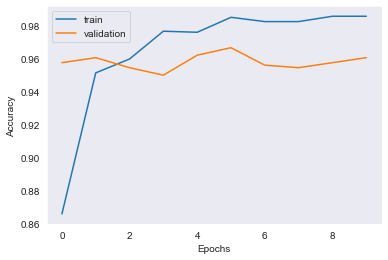

In [30]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.legend(['train', 'validation'])

plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [4]:
model.save('Models/model.h5')

In [9]:
from tensorflow.keras.models import load_model
savedModel=load_model('Models/model.h5')

## Sample Prediction

**Printing the image**

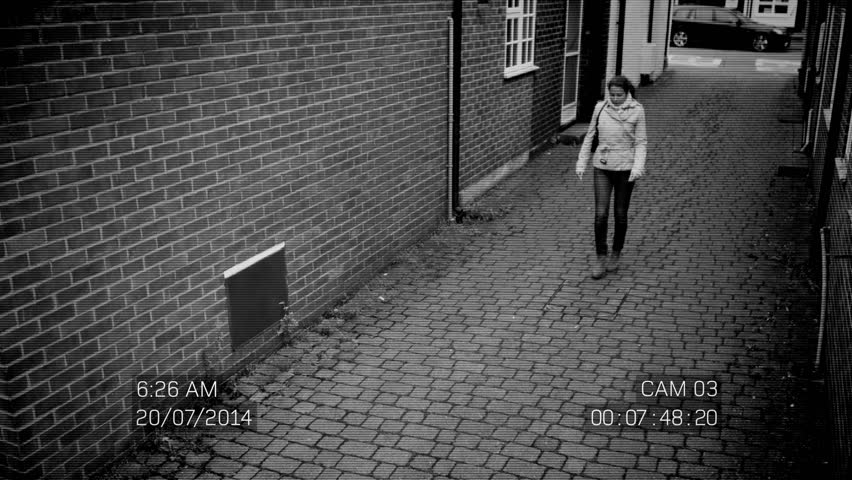

In [20]:
img = image.load_img('check1.jpg')
img

In [21]:
img = image.img_to_array(img)/255
img = tf.image.resize(img,(224,224))
img = tf.expand_dims(img,axis=0)

print("Image Shape",img.shape)

Image Shape (1, 224, 224, 3)


In [16]:
prediction = int(tf.round(savedModel.predict(x=img)).numpy()[0][0])
print("The predicted value is: ",prediction,"and the predicted label is:",class_indices[prediction])

The predicted value is:  1 and the predicted label is: non_fire
